## Importing Libraries and Data Set

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Load and Clean Data
df = pd.read_csv('../data/us_disaster_declarations.csv')

2025-01-27 05:16:02.594673: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-27 05:16:03.156038: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-27 05:16:03.393209: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737954963.719432   46323 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737954963.772395   46323 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-27 05:16:04.481094: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

## Data Clean Up and Dropping Columns

In [2]:
# Filter for mainland states
mainland_states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA", 
                   "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
                   "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
                   "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
                   "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
df = df[df['state'].isin(mainland_states)]
# Filter for specific disaster types
target_disasters = ["Tornado", "Fire", "Severe Storm", "Flood", "Hurricane"]
df = df[df['incident_type'].isin(target_disasters)]


# Drop irrelevant columns
columns_to_drop = [
    "fema_declaration_string", "fips", "place_code", "hash", "id", "last_refresh", 
    "last_ia_filing_date", "fy_declared", "ih_program_declared", "ia_program_declared", 
    "declaration_type", "pa_program_declared", "hm_program_declared", 
    "disaster_closeout_date", "declaration_request_number"
]
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44586 entries, 0 to 64091
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   disaster_number      44586 non-null  int64 
 1   state                44586 non-null  object
 2   declaration_date     44586 non-null  object
 3   incident_type        44586 non-null  object
 4   declaration_title    44586 non-null  object
 5   incident_begin_date  44586 non-null  object
 6   incident_end_date    44041 non-null  object
 7   designated_area      44586 non-null  object
dtypes: int64(1), object(7)
memory usage: 3.1+ MB


## Converting Dates and Aggregate Monthly Disaster Counts

In [4]:
# Convert dates and sort
df['incident_begin_date'] = pd.to_datetime(df['incident_begin_date']).dt.tz_localize(None)
df.sort_values('incident_begin_date', inplace=True)

# Aggregate monthly disaster counts
monthly_disasters = df.groupby(pd.Grouper(freq='M', key='incident_begin_date')).size()
monthly_disasters = monthly_disasters.to_frame(name='disaster_count')

/tmp/ipykernel_46323/1553042575.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_disasters = df.groupby(pd.Grouper(freq='M', key='incident_begin_date')).size()


## Working with logging Outliers and Features for Seasonality

In [5]:

# Log transformation to manage outliers
monthly_disasters['disaster_count'] = np.log1p(monthly_disasters['disaster_count'])

# Add cyclical features for seasonality
monthly_disasters['month_sin'] = np.sin(2 * np.pi * (monthly_disasters.index.month / 12))
monthly_disasters['month_cos'] = np.cos(2 * np.pi * (monthly_disasters.index.month / 12))

## Scaling the Data

In [6]:

# Normalize Data
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(monthly_disasters)
scaled_df = pd.DataFrame(scaled_features, columns=monthly_disasters.columns, index=monthly_disasters.index)
# Create Sequences
def create_sequences(data, seq_length):
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        seq = data.iloc[i:i + seq_length].values
        label = data.iloc[i + seq_length, 0]  # Predict disaster count
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)
seq_length = 36  # Increased sequence length to capture longer dependencies
X, y = create_sequences(scaled_df, seq_length)

## Train Test Split

In [7]:

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

## Building LSTM Model

In [8]:
# Build the Bidirectional LSTM Model
model = Sequential([
    Bidirectional(LSTM(64, activation='relu', return_sequences=False, input_shape=(seq_length, X_train.shape[2]))),
    Dropout(0.4),  # Increased dropout for regularization
    Dense(1)  # Output disaster count
])

# Compile the Model
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')  # Lower learning rate for fine-tuning

# Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the Model
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluate the Model
y_pred = model.predict(X_test)

# Rescale Predictions
y_pred_rescaled = np.expm1(y_pred)  # Reverse log transformation
y_test_rescaled = np.expm1(y_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
print(f"Root Mean Squared Error (RMSE): {rmse}")


2025-01-27 05:16:11.831517: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/vscode/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50


41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0849 - val_loss: 0.0600
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0438 - val_loss: 0.0419
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0406 - val_loss: 0.0453
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0398 - val_loss: 0.0403
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0417 - val_loss: 0.0394
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0370 - val_loss: 0.0408
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0414 - val_loss: 0.0409
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0367 - val_loss: 0.0406
Epoch 9/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0399 - val_loss: 0.0393
Epoch 10/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0373 - val_loss: 0.0410
Epoch 11/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0364 - val_loss: 0.0395
Epoch 12/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0370 - val_l

## Plotting the Results

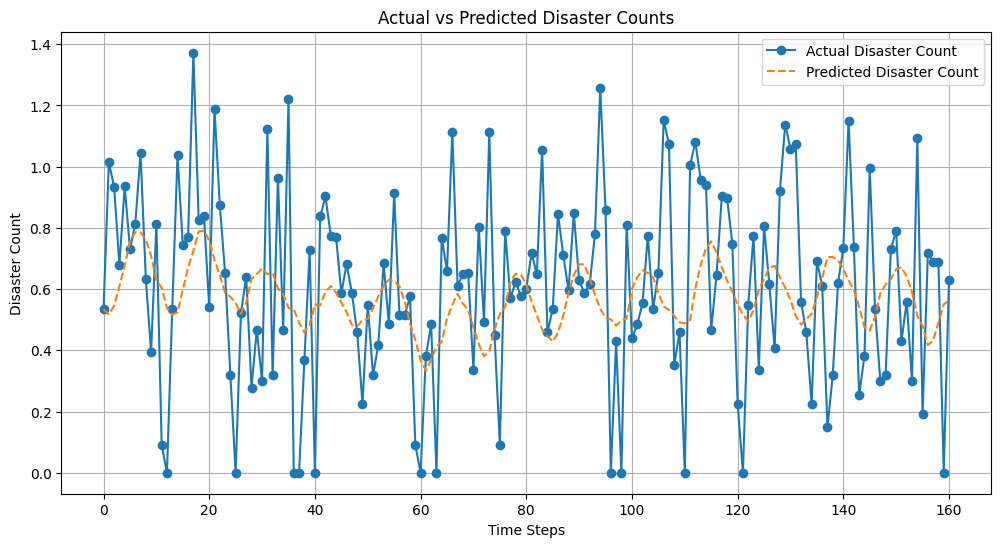

In [9]:

# Plot Results
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Actual Disaster Count', marker='o')
plt.plot(y_pred_rescaled, label='Predicted Disaster Count', linestyle='--')
plt.title('Actual vs Predicted Disaster Counts')
plt.xlabel('Time Steps')
plt.ylabel('Disaster Count')
plt.legend()
plt.grid()
plt.show()


Overall the model is predicting well but still has error. Still want to make sure its not aggregating the states together and predicting separately. At this point what seems to need to be done is treating individual areas differently. Where-in some states with less data it is best to aggregate the date quarterly and with high volume to aggregate the data monthly. Ill group areas of the states together to hopefully help the model identify disasters in close proximity.


In [ ]:

# Define state groupings
high_freq_states = ["FL", "LA", "TX", "CA", "MS", "AL", "NC"]
low_freq_states = ["ME", "NV", "VT", "NH", "WY"]

# Group similar states
regional_groups = {
    "Gulf_Coast": ["FL", "LA", "MS", "AL", "TX"],
    "Midwest": ["KS", "OK", "IA", "NE", "MO"],
    "West_Coast": ["CA", "OR", "WA"],
    "Northeast": ["NY", "NJ", "MA", "CT", "RI", "PA"],
}

# Function to aggregate and train models
def train_state_group(group_name, states, aggregation):
    print(f"\nTraining for group: {group_name} with {aggregation} aggregation")
    group_df = df[df['state'].isin(states)].copy()
    
    # Resample data
    group_df.set_index('incident_begin_date', inplace=True)
    disaster_counts = group_df.resample(aggregation).size().to_frame(name='disaster_count')
    
    # Log transformation to handle skewness
    disaster_counts['disaster_count'] = np.log1p(disaster_counts['disaster_count'])
    
    # Add cyclical features
    disaster_counts['month_sin'] = np.sin(2 * np.pi * (disaster_counts.index.month / 12))
    disaster_counts['month_cos'] = np.cos(2 * np.pi * (disaster_counts.index.month / 12))
    
    # Normalize data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(disaster_counts)
    scaled_df = pd.DataFrame(scaled_data, columns=disaster_counts.columns, index=disaster_counts.index)
    
    # Create sequences
    def create_sequences(data, seq_length=36):
        sequences, labels = [], []
        for i in range(len(data) - seq_length):
            seq = data.iloc[i:i + seq_length].values
            label = data.iloc[i + seq_length, 0]
            sequences.append(seq)
            labels.append(label)
        return np.array(sequences), np.array(labels)

    X, y = create_sequences(scaled_df)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
    
    # Build the model
    model = Sequential([
        Bidirectional(LSTM(64, activation='relu', return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2]))),
        Dropout(0.4),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train the model
    history = model.fit(
        X_train, y_train, 
        epochs=50, 
        batch_size=16, 
        validation_data=(X_test, y_test), 
        callbacks=[early_stopping], 
        verbose=1
    )
    
    # Evaluate the model
    y_pred = model.predict(X_test)
    y_pred_rescaled = np.expm1(y_pred)
    y_test_rescaled = np.expm1(y_test)
    rmse = np.sqrt(np.mean((y_pred_rescaled - y_test_rescaled)**2))
    print(f"Group: {group_name}, RMSE: {rmse}")
    return rmse

# Train models for each group
results = {}
for group_name, states in regional_groups.items():
    aggregation = "M" if set(states).intersection(high_freq_states) else "Q"
    results[group_name] = train_state_group(group_name, states, aggregation)

# Print results
print("\nRMSE Summary:")
for group, rmse in results.items():
    print(f"{group}: RMSE = {rmse}")



Training for group: Gulf_Coast with M aggregation
Epoch 1/50


/tmp/ipykernel_46323/789506953.py:26: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  disaster_counts = group_df.resample(aggregation).size().to_frame(name='disaster_count')
/home/vscode/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.1284 - val_loss: 0.0884
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1042 - val_loss: 0.0902
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0891 - val_loss: 0.0961
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0874 - val_loss: 0.0942
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0967 - val_loss: 0.0914
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0949 - val_loss: 0.0880
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0818 - val_loss: 0.0858
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0907 - val_loss: 0.0854
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0903 - val_loss: 0.0851
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0942 - val_loss: 0.0857
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0828 - val_loss: 0.0864
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0974 - val_loss: 0.0851
Epoch 13/50


/tmp/ipykernel_46323/789506953.py:26: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  disaster_counts = group_df.resample(aggregation).size().to_frame(name='disaster_count')
/home/vscode/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 37s 37s/step - loss: 0.2766 - val_loss: 0.0936
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - loss: 0.2877 - val_loss: 0.0847
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.2253 - val_loss: 0.0765
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.2669 - val_loss: 0.0690
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.2052 - val_loss: 0.0622
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.2420 - val_loss: 0.0562
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.2174 - val_loss: 0.0508
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.1893 - val_loss: 0.0462
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.1829 - val_loss: 0.0423
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.1937 - val_loss: 0.0392
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.1806 - val_loss: 0.0370
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.1541 - val_loss: 0.0356
Epoc

/tmp/ipykernel_46323/789506953.py:26: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  disaster_counts = group_df.resample(aggregation).size().to_frame(name='disaster_count')
/home/vscode/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 0.1335 - val_loss: 0.1462
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1202 - val_loss: 0.1129
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0953 - val_loss: 0.0992
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0835 - val_loss: 0.0973
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0899 - val_loss: 0.0968
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0965 - val_loss: 0.0974
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0812 - val_loss: 0.0990
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0765 - val_loss: 0.0988
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0737 - val_loss: 0.0972
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0718 - val_loss: 0.0947
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0877 - val_loss: 0.0930
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0839 - val_loss: 0.0922
Epoch 13/50


/tmp/ipykernel_46323/789506953.py:26: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  disaster_counts = group_df.resample(aggregation).size().to_frame(name='disaster_count')
/home/vscode/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0800 - val_loss: 0.2354
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.0694 - val_loss: 0.2269
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0870 - val_loss: 0.2206
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0719 - val_loss: 0.2144
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.0795 - val_loss: 0.2092
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.0734 - val_loss: 0.2053
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.1095 - val_loss: 0.2027
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.0672 - val_loss: 0.2003
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0702 - val_loss: 0.1982
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0601 - val_loss: 0.1959
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0810 - val_loss: 0.1940
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.0656 - val_loss: 0.1926
Epoch 13